<a href="https://www.kaggle.com/code/khairullahilyas/adaro-stock-price-forecasting-with-lstm?scriptVersionId=186944522" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Time-series forecasting is to predict the values of a set of
future data points given a set of past observations. Time series forecasting has wide applications in various fields, such as finance, logistics, and manufacturing. There are many models utilized for predicting tasks. The LSTM (Long Short-Term Memory) model is an artificial neural network that is effective for predicting time series data because of its ability to capture long-term dependencies in the data. This report aims to demonstrate the application of LSTM in time series forecasting.

<img src="https://stockprice.com/wp-content/uploads/2018/09/stock_price_market-768x500.jpg">

The dataset used in this report is the time series of PT Adaro Energy Indonesia Tbk (ADRO) share prices. This data can be obtained from Yahoo Finance. PT Adaro Energy Indonesia Tbk is an Indonesian coal mining company, the country's second-largest by production volume and largest by market capitalization.

### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import Dataset

In [3]:
df = pd.read_csv("/kaggle/input/adaro-stock-price-dataset/ADRO.JK.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-07-16,1500.0,1760.0,1500.0,1730.0,664.123718,789786000.0
1,2008-07-17,1700.0,1760.0,1700.0,1700.0,652.606934,383602500.0
2,2008-07-18,1640.0,1700.0,1640.0,1640.0,629.573730,95396000.0
3,2008-07-21,1680.0,1690.0,1640.0,1680.0,644.929443,49749000.0
4,2008-07-22,1670.0,1690.0,1660.0,1670.0,641.090454,29585500.0


### Simple Visualization

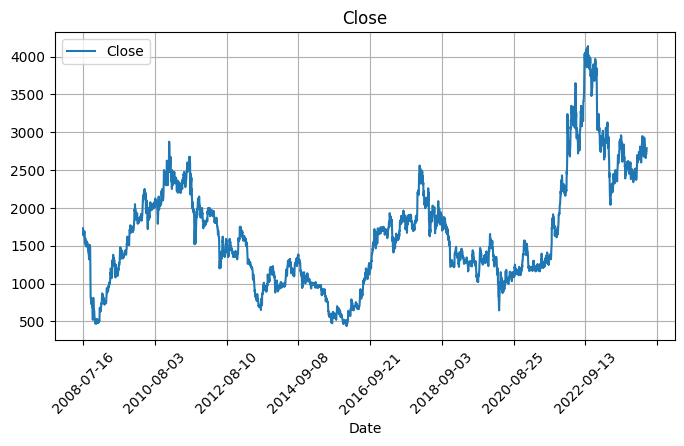

In [4]:
df.plot(kind='line', x='Date',y='Close', figsize=(8, 4), title='Close')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Split the Timeseries

In [5]:
# train-test split for time series
timeseries = df[["Close"]].values.astype('float32')
train_size = int(len(timeseries) * 0.67)
val_size = int(len(timeseries)*0.96)
test_size = int(len(timeseries))

In [6]:
train = timeseries[:train_size]
val = timeseries[train_size:val_size]
test = timeseries[val_size:]

### Add Features

According to David Lengacher (2018), including the lag feature when building an LSTM model can make the model work better. Although LSTM is a model that can learn time dependency.

In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [8]:
lookback = 28
X_train, y_train = create_dataset(train, lookback=lookback)
X_val, y_val = create_dataset(val, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([2603, 28, 1]) torch.Size([2603, 28, 1])
torch.Size([1111, 28, 1]) torch.Size([1111, 28, 1])
torch.Size([130, 28, 1]) torch.Size([130, 28, 1])


In [9]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

### Define the Model

In [10]:
class LSTM(nn.Module):
  """
  Long Short-Term Memory (LSTM) network for time series forecasting.

  This class defines a basic LSTM architecture with the following properties:

  - input_size: Dimensionality of the input features.
  - hidden_size: Number of units in the hidden layer of the LSTM cell.
  - output_size: Dimensionality of the output (number of predicted values).
  - num_layers: Number of stacked LSTM layers.
  - batch_first: Whether the first dimension represents the batch size (True)
                 or the sequence length (False). Defaults to True.
  """

  def __init__(self, input_size, hidden_size, output_size, num_layers, batch_first=True):
    """
    Initializes the LSTM model.
    """
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    """
    Performs the forward pass of the LSTM model.

    Args:
      x: Input tensor of shape (batch_size, sequence_length, input_size).

    Returns:
      Output tensor of shape (batch_size, sequence_length, output_size).
    """
    # Pass the input through the LSTM layers
    x, _ = self.lstm(x)
    # Apply a linear layer to transform the hidden state to the output size
    x = self.linear(x)
    return x


In [11]:
# Define hyperparameters for the LSTM model
input_size = 1  # Dimensionality of the input features (assuming single feature)
hidden_size = 128  # Number of units in the hidden layer of the LSTM cell
output_size = 1  # Dimensionality of the output (single predicted value)
num_layers = 2  # Number of stacked LSTM layers

# Create an LSTM model instance
model = LSTM(input_size, hidden_size, output_size, num_layers).to(device)

# Define the optimizer for training the model (Adam optimizer with learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function for evaluating model performance (Mean Squared Error)
loss_fn = nn.MSELoss().to(device)

# Create a data loader for training
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

### Train the Model

In [12]:
# Define the number of epochs for training (total training iterations)
n_epochs = 1000

# Training loop
for epoch in range(n_epochs):
  # Set the model to training mode
  model.train()

  # Iterate through batches of data from the data loader
  for X_batch, y_batch in loader:
    # Move the data to the device (CPU or GPU) for efficient training
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Perform a forward pass through the model to get predictions
    y_pred = model(X_batch)

    # Calculate the loss (MSE) between predictions and actual targets
    loss = loss_fn(y_pred, y_batch)

    # Clear gradients from the previous iteration
    optimizer.zero_grad()

    # Backpropagate the loss to update model weights
    loss.backward()

    # Update model weights using the optimizer (Adam with learning rate)
    optimizer.step()

  # Perform validation every 20th epoch
  if epoch % 20 != 0:
    continue

  # Set the model to evaluation mode (suspend weight updates)
  model.eval()

  # Disable gradient calculation for validation (saves memory)
  with torch.no_grad():
    # Get predictions on the training data for monitoring
    y_pred_train = model(X_train)
    # Calculate train MSE and RMSE
    train_mse = loss_fn(y_pred_train.to(device), y_train)
    train_rmse = np.sqrt(train_mse.cpu())

    # Get predictions on the validation data for evaluation
    y_pred_val = model(X_val)
    # Calculate validation MSE and RMSE
    val_mse = loss_fn(y_pred_val.to(device), y_val)
    val_rmse = np.sqrt(val_mse.cpu())

  # Print the epoch number, train RMSE, and validation RMSE
  print("Epoch %d: train RMSE %.4f, val RMSE %.4f" % (epoch, train_rmse, val_rmse))

Epoch 0: train RMSE 1540.4413, val RMSE nan
Epoch 20: train RMSE 1349.9725, val RMSE nan
Epoch 40: train RMSE 1175.7472, val RMSE nan
Epoch 60: train RMSE 1013.9551, val RMSE nan
Epoch 80: train RMSE 867.0187, val RMSE nan
Epoch 100: train RMSE 740.3015, val RMSE nan
Epoch 120: train RMSE 641.8991, val RMSE nan
Epoch 140: train RMSE 579.2429, val RMSE nan
Epoch 160: train RMSE 551.9974, val RMSE nan
Epoch 180: train RMSE 546.1459, val RMSE nan
Epoch 200: train RMSE 333.8824, val RMSE nan
Epoch 220: train RMSE 247.1532, val RMSE nan
Epoch 240: train RMSE 201.2467, val RMSE nan
Epoch 260: train RMSE 150.4038, val RMSE nan
Epoch 280: train RMSE 106.0167, val RMSE nan
Epoch 300: train RMSE 80.5086, val RMSE nan
Epoch 320: train RMSE 63.4904, val RMSE nan
Epoch 340: train RMSE 59.1634, val RMSE nan
Epoch 360: train RMSE 51.6247, val RMSE nan
Epoch 380: train RMSE 51.6190, val RMSE nan
Epoch 400: train RMSE 46.4269, val RMSE nan
Epoch 420: train RMSE 44.0892, val RMSE nan
Epoch 440: train RM

### Results

In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred_train = model(X_train)
    y_pred_train = y_pred_train.cpu()
    y_pred_train = y_pred_train[:, -1, :]
    train_plot[lookback:train_size] = y_pred_train
    # shift val predictions for plotting
    val_plot = np.ones_like(timeseries) * np.nan
    y_pred_val = model(X_val)
    y_pred_val = y_pred_val.cpu()
    y_pred_val = y_pred_val[:, -1, :]
    val_plot[train_size+lookback:val_size] = y_pred_val
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    y_pred_test = model(X_test)
    y_pred_test = y_pred_test.cpu()
    y_pred_test = y_pred_test[:, -1, :]
    test_plot[val_size+lookback:len(timeseries)] = y_pred_test

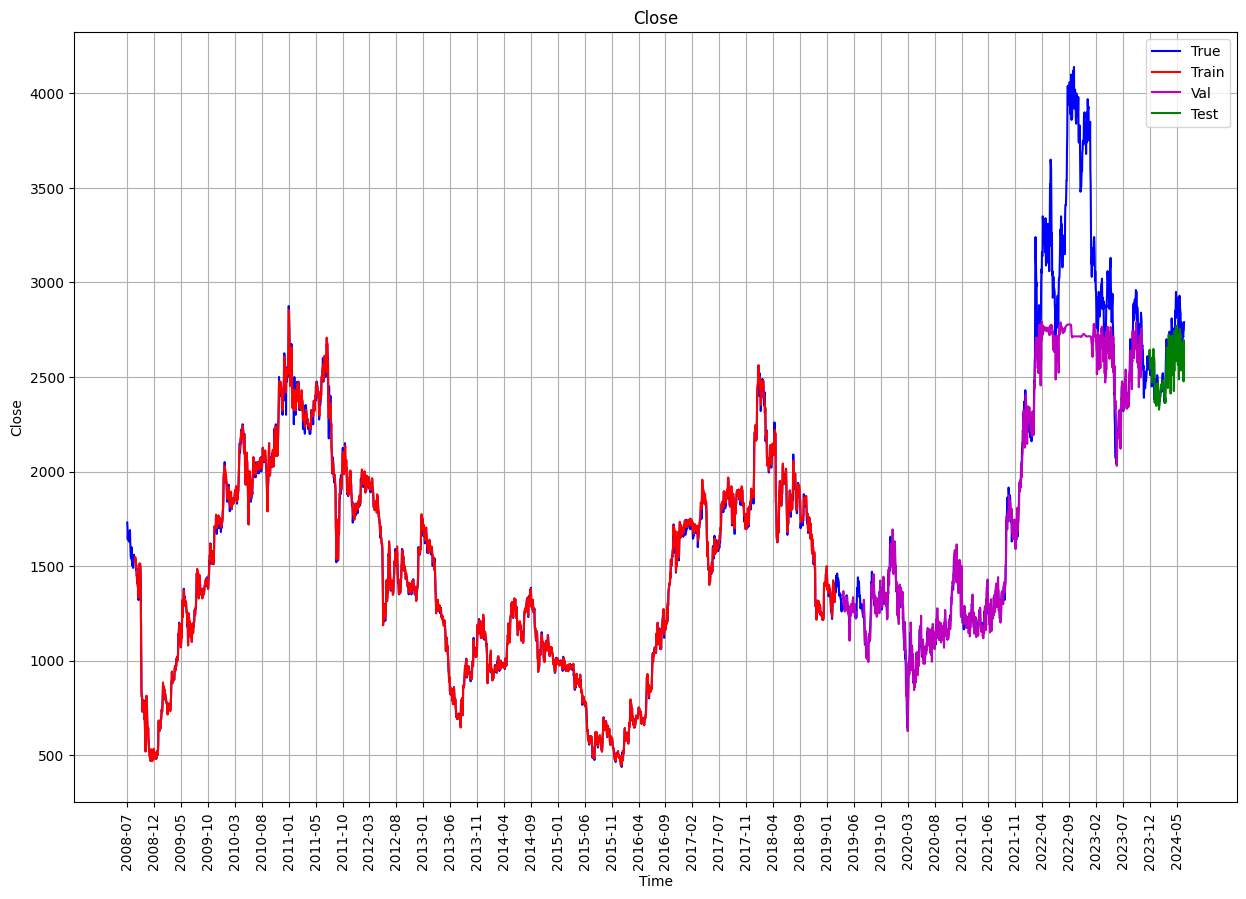

In [14]:
tick_positions = np.arange(0, len(df.index), 100)
custom_labels = [pd.to_datetime(df['Date']).loc[i].strftime('%Y-%m') for i in tick_positions]  # Create custom labels for tick positions

# Plot
plt.figure(figsize=(15,10))
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(val_plot, c='m')
plt.plot(test_plot, c='g')
plt.legend(labels=['True', 'Train','Val', 'Test'])
plt.title('Close')
plt.xlabel('Time')
plt.ylabel('Close')
plt.xticks(tick_positions, custom_labels,rotation=90)
plt.grid()
plt.show()

The model works well on training data. In the validation data, there was a miscalculation from August 2022 to November 2022. This is understandable because in that range there was a significant and unprecedented fluctuation, so the model could not predict it. However, for test data, it seems like the model can work quite well.

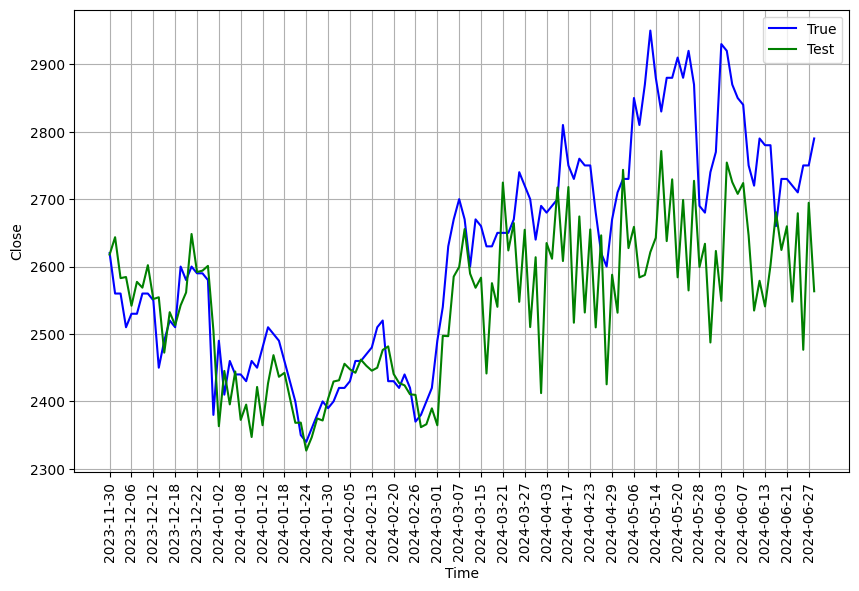

In [15]:
test_date = df['Date'].loc[val_size+lookback:len(timeseries)]
test_date = pd.to_datetime(test_date)
tick = np.arange(0, len(test_date), int(len(test_date)/30)) # Adjust the step size here to get around 30 ticks
custom = [test_date.iloc[i].strftime('%Y-%m-%d') for i in tick] # Use iloc for integer-based indexing

plt.figure(figsize=(10,6))
plt.plot(timeseries[val_size+lookback:len(timeseries)], c='b')
plt.plot(test_plot[val_size+lookback:len(timeseries)], c='g')
plt.legend(labels=['True', 'Test'])
plt.xlabel('Time')
plt.ylabel('Close')
plt.xticks(tick, custom, rotation=90)
plt.grid()
plt.show()

In [16]:
true_value = timeseries[val_size+lookback:len(timeseries)]
predicted_value = test_plot[val_size+lookback:len(timeseries)]
mse = mean_squared_error(true_value, predicted_value)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 126.080795


Based on RMSE, it can be seen that stock price predictions are decent. Based on the graph, it can be seen that from 2023-11-30 to 2024-03-07, the model is quite reliable for predicting stock prices. However, after that date, the model appears to start producing deviations in values. 

There are many factors that influence stock prices that make predictions unfeasible, but predictions that have just been made can be a learning tool and a space for discussion. Thank you for taking your time to read this notebook until the end. One upvote from you is an encouragement for me. That is all and thank you.

- Tam, Adrian (2023). LSTM for Time Series Prediction in PyTorch. Available at : https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/.
- Lengacher, David (2018). LSTMs with Lagged Data :
Should you use lagged data when building an LSTM?. Available at : https://medium.com/@dclengacher/lstms-with-lagged-data-cc03a3a8cfcf
- Pytorch LSTM Documentation. Available at : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html